1. Crie uma MLP genérica para modelo de classificação binária (ou não) implementando forward, backward e loss.
    
    a. É necessário que o usuário possa definir quantas layers e neurônios desejar
    
    b. É necessário que a loss utilizada seja binary cross-entropy (estude um pouco mais sobre esse tópico)
    
    c. É necessário que a rede funcione para diferentes datasets de classificação, considerando que o dado de entrada para o modelo já esteja no formato desejado, como por exemplo número de features, target binário.
    
    d. É necessário que a  função de ativação da layer de output retorne uma probabilidade (entre 0 e 1), então use algo como sigmoid por exemplo.
    
    e. A regra de update dos pesos pode ser feita utilizando a regra básica do gradient descent (weight = weight - learning_rate * gradient)
2. (Opcional - Difícil 1) Crie uma MLP para classificar o dataset MNIST e faça as adaptações necessárias
3. (Opcional - Difícil 2) Crie um otimizador para update dos pesos utilizando o gradient e learning_rate. Como por exemplo, o otimizador Adam.
As informações da aula de hoje estão dentro do repositório de lectures/users/luisa/NN/XOR-zero.ipynb. Se precisarem das informações escritas posso emprestar meus rascunhos.


Defining generic Layer class

In [144]:
import numpy as np
import math

class NetOperation():

  def forward():
    pass

  def backward():
    pass

  def optimize():
    pass

class Layer(NetOperation):
  def __init__(self, n_in: int, n_out: int):
    self.weights = np.random.randn(n_in, n_out)
    self.bias = np.zeros(shape=(1, n_out))

  # z = a1w1 + a2w2 + a3w3 + ... + b
  def forward(self, a):
    self.a = a
    return a.dot(self.weights) + self.bias

  # dgrad = dL / z
  # dL / dwi = dL / dz * dz / dwi
  def backward(self, grad):
    # print(f'Layer backward grad received: {grad}')
    self.grad_weights = self.a.T.dot(grad)
    self.grad_bias = np.mean(grad, axis=0)
    # DUVIDA PRIMORDIAL (PRECISO VER ISSO, NÃO ENTENDI MUITO BEM)
    # peguei do código da luiza a ideia
    return grad.dot(self.weights.T)

  def optimize(self, learning_rate):
    # print(f'Doing optimization with: {self.grad_weights}')
    self.weights -= self.grad_weights * learning_rate
    self.grad_weights = None

    self.bias -= self.grad_bias * learning_rate
    self.grad_bias = None

class ReLU(NetOperation):
  # a: activation
  # z: weighted sum

  # a = f(z)
  def f(self, z):
    return np.maximum(0, z)
  
  # da / dz
  # a = df(z)
  def df(self, z):
    return np.greater(0, z).astype(int)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  # dgrad = dL / da
  # dL / dz = da / dz * dL / da
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
  
class Sigmoid(NetOperation):
  # a: activation
  # z: weighted sum

  def f(self, z):
    return 1 / (1 + np.exp(-z))
  
  def df(self, z):
    s = self.f(z)
    return s * (1 - s)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
    

In [145]:
from matplotlib import pyplot as plt
# https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c
def BCELoss(prediction, target):
  n = len(target)
  return (1 / n) * np.sum(-target * np.log(prediction) - (1 - target) * np.log(1 - prediction))


def dBCELoss(prediction, target):
  n = len(target)
  return (1 / n) * (- target / prediction + (1 - target) / (1 - prediction))

class MLP(NetOperation):
  layers: list[NetOperation]

  def __init__(self, n_features: int, neurons_per_layer: list[int]):
    input_layer = [Layer(n_features, neurons_per_layer[0])]
    hidden_layers = []

    for i in range(len(neurons_per_layer) - 1):
    
      hidden_layers.extend([Sigmoid(), Layer(neurons_per_layer[i], neurons_per_layer[i + 1])])


    self.layers = input_layer + hidden_layers + [Sigmoid()]


  def forward(self, x):
    activation = x

    # print(f"Forward initial activation: {activation}")

    for layer in self.layers:
      # print(f"At layer {layer}")
      activation = layer.forward(activation)
      # print(f"New activation: {activation}")

    return activation
  
  # [Sigmoid(), Layer, ReLU, Layer, ReLU, Layer]
  # propagate error
  def backward(self, grad):
    self.layers.reverse()
    
    for layer in self.layers:
      grad = layer.backward(grad)

    self.layers.reverse()

  def optimize(self, learning_rate):
    for i, layer in enumerate(self.layers):
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights before optimize:")
      #   print(layer.weights)
      layer.optimize(learning_rate)
      # if hasattr(layer, 'weights'):
      #   print(f"Layer {i} weights after optimize:")
      #   print(layer.weights)

  def train(self, X, Y, learning_rate, batch_size, epochs):
        
    xs = range(epochs)
    accuracies = []
    for epoch in xs:
      print(f'Epoch {epoch}')
      hits = 0
      for i in range(0, len(X), batch_size):
        train_samples = X[i : i + batch_size]
        target_samples = Y[i : i + batch_size]


        predictions = self.forward(train_samples)
        print(f'predictions: {predictions}')
        print(f'target_samples: {target_samples}')
        error = BCELoss(predictions, target_samples)
        d_bce_loss = dBCELoss(predictions, target_samples)
        print(f'error: {error}')
        print(f'd_bce_loss: {d_bce_loss}')
        self.backward(d_bce_loss)
        self.optimize(learning_rate)

        hits += (predictions > 0.5) == target_samples

      accuracies.append((hits / len(X)).reshape(-1)[0])

      print(f'Accuracy: {hits / len(X)}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.plot(xs, accuracies)

Train

Epoch 0
predictions: [[0.99921211]]
target_samples: [0]
error: 7.146146562246237
d_bce_loss: [[1269.20571463]]
predictions: [[3.08138817e-31]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[4.86779651e-35]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[2.298162e-41]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[1.31613219e-27]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[4.78261573e-46]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[4.49980651e-39]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[3.26314665e-36]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[1.36344834e-36]]
target_samples: [0]
error: 0.0
d_bce_loss: [[1.]]
predictions: [[6.85864758e-26]]
target_samples: [1]
error: 57.94170214086952
d_bce_loss: [[-1.45801339e+25]]
predictions: [[6.63686604e-13]]
target_samples: [0]
error: 6.636913241211388e-13
d_bce_loss: [[1.]]
predictions: [[1.00140671e

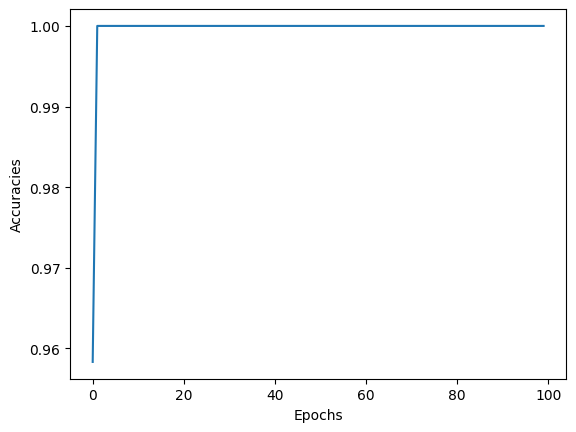

In [148]:
from iris import train

net = MLP(4, [1])
net.train(train['data'], train['target'], learning_rate=1, batch_size=1, epochs=100)


Test

In [149]:
from iris import test


predictions = net.forward(test['data'])
BCELoss(predictions.reshape(-1), test['target'])

4.7759837493938784e-05

MNIST

In [ ]:
from keras.datasets import mnist
# (train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X.shape: (60000, 784)
train_y.shape: (60000,)
test_X.shape: (10000, 784)
test_y.shape: (10000,)


IndexError: tuple index out of range

In [ ]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
net = MLP(28 * 28, [100, 10])

net.train(train_X, train_y, 0.001, 1, 1000)

Epoch 0
predictions: [[0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]
target_samples: [5]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [0]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [4]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [9]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [2]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [3]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [4]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [3]
error: nan
predictions: [[nan nan nan nan nan

/tmp/ipykernel_12617/2031617849.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_12617/1141588724.py:7: RuntimeWarning: divide by zero encountered in log
  return (1 / n) * np.sum(-target * np.log(prediction) - (1 - target) * np.log(1 - prediction))
/home/guilhermealvesc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_12617/1141588724.py:12: RuntimeWarning: divide by zero encountered in divide
  return (1 / n) * (- target / prediction + (1 - target) / (1 - prediction))
/tmp/ipykernel_12617/2031617849.py:84: RuntimeWarning: invalid value encountered in multiply
  return self.df(self.z) * grad


predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [7]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [2]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [6]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [0]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [3]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [0]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [1]
error: nan
predictions: [[nan nan nan nan nan nan nan nan nan nan]]
target_samples: [8]
error: nan
predictions: [[nan nan nan nan n

KeyboardInterrupt: 